# Feature Engineering and EDA

In [1]:
import re
import numpy as np
import pandas as pd
import pickle
import gensim
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

In [6]:
file = open('articles.p', 'rb')      
df = pickle.load(file)
file.close()

In [7]:
drop_indices = df.loc[df['date'] < pd.Timestamp(2019, 3, 15)].index
df.drop(index=drop_indices, inplace=True)

In [9]:
# Drop update articles and investing articles
df = df.loc[df['headline'].map(lambda x: re.search(r'UPDATE', x)).isna()]
df = df.loc[df['headline'].map(lambda x: re.search(r'US STOCKS', x)).isna()]
df = df.loc[df['headline'].map(lambda x: re.search(r'PRESS', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'investing', x)).isna()]
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.drop(columns='url', inplace=True)

## Add sentences and words features

In [10]:
def replace_words(text):
    text = re.sub(r'U\.S\.', 'US', text)
    text = re.sub(r'US\s', 'USA ', text)
    text = re.sub(r'Kongs', 'Kong', text)
    text = re.sub(r'Hong Kong', 'HongKong', text)
    text = re.sub(r'U\.K\.', 'UK', text)
    text = re.sub(r'Mr\.', 'MR', text)
    text = re.sub(r'Mrs\.', 'MRS', text)
    text = re.sub(r'Ms\.', 'MS', text)
    text = re.sub(r'\.\.\.', '', text)
    text = re.sub(r'U.S-China', 'US-China', text)
    text = re.sub(r'(\.)(\w)', r'\1 \2', text)
    text = text.replace('Co.', 'Co')
    text = text.replace('\xa0', '')
    text = text.replace('."', '".')
    text = text.replace('immediatelywith', 'immediately with')
    text = text.replace('theOfficeof', 'the Office of')
    text = text.replace('theCommissionerof', 'the Commissioner of')
    text = text.replace('entirelywithin', 'entirely within')
    
    return text

In [11]:
df['body'] = df['body'].map(replace_words)

In [12]:
def preprocess(text):
    stop_words = stopwords.words('english')
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words:
            result.append(WordNetLemmatizer().lemmatize(token, pos='v'))
    return ' '.join(result)

In [13]:
def preprocess_all(listy):
    results = [ preprocess(text) for text in listy ]
    return results

In [14]:
# Tokenize body sentences, keep first 10 sentences
df['sentence_tokens'] = df['body'].map(lambda x: sent_tokenize(x)[:10])

In [15]:
df['sentences'] = df['body'].map(lambda x: sent_tokenize(x)[:10])

In [16]:
# Preprocess sentences
df['sentence_tokens'] = df['sentence_tokens'].map(preprocess_all)

# Form word tokens from the sentences
df['word_tokens'] = df['sentence_tokens'].map(lambda x: ' '.join(x).split())

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 7 columns):
date               2965 non-null datetime64[ns]
headline           2965 non-null object
body               2965 non-null object
source             2965 non-null object
sentence_tokens    2965 non-null object
sentences          2965 non-null object
word_tokens        2965 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 162.3+ KB


## Dictionary and bigram/trigram models
- This section heavily takes from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [18]:
data_words = df['word_tokens']

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
def make_bigrams(texts):
    return [ bigram_mod[doc] for doc in texts ]

def make_trigrams(texts):
    return [ trigram_mod[bigram_mod[doc]] for doc in texts ]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([ token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return texts_out

In [21]:
# Form Bigrams and Trigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
data_words_bigrams

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter extremes from dictionary
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [ id2word.doc2bow(text) for text in texts ]

In [23]:
# Create TF-IDF corpus
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## LDA Models

In [44]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       workers=2,
                                       num_topics=5, 
                                       random_state=100,
                                       passes=10,
                                       per_word_topics=True)

In [45]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"government" + 0.012*"would" + 0.012*"student" + 0.011*"police" + '
  '0.010*"city" + 0.009*"election" + 0.009*"law" + 0.009*"also" + '
  '0.006*"people" + 0.006*"call"'),
 (1,
  '0.020*"year" + 0.013*"city" + 0.010*"government" + 0.009*"would" + '
  '0.007*"month" + 0.007*"business" + 0.007*"company" + 0.006*"also" + '
  '0.006*"market" + 0.006*"time"'),
 (2,
  '0.048*"police" + 0.035*"protester" + 0.016*"arrest" + 0.012*"officer" + '
  '0.010*"people" + 0.008*"attack" + 0.007*"man" + 0.006*"student" + '
  '0.006*"force" + 0.006*"charge"'),
 (3,
  '0.033*"protester" + 0.026*"police" + 0.012*"people" + 0.011*"use" + '
  '0.009*"station" + 0.009*"also" + 0.007*"call" + 0.006*"violence" + '
  '0.006*"government" + 0.006*"city"'),
 (4,
  '0.016*"chinese" + 0.011*"government" + 0.011*"people" + 0.010*"protester" + '
  '0.010*"also" + 0.009*"would" + 0.009*"city" + 0.008*"call" + '
  '0.008*"support" + 0.006*"make"')]


In [46]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.8705044614761945

Coherence Score:  0.38590898213873626


In [47]:
tfidf_lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
                                             id2word=id2word,
                                             workers=2,
                                             num_topics=5,
                                             random_state=100,
                                             passes=10,
                                             per_word_topics=False)

In [48]:
pprint(tfidf_lda_model.print_topics())
doc_tfidf_lda = tfidf_lda_model[corpus]

[(0,
  '0.010*"student" + 0.008*"school" + 0.006*"teacher" + 0.005*"decision" + '
  '0.005*"court" + 0.004*"law" + 0.004*"rule" + 0.004*"case" + 0.004*"legal" + '
  '0.004*"game"'),
 (1,
  '0.011*"year" + 0.009*"flight" + 0.008*"airline" + 0.005*"sale" + '
  '0.005*"drop" + 0.005*"visitor" + 0.005*"company" + 0.005*"profit" + '
  '0.004*"decline" + 0.004*"impact"'),
 (2,
  '0.004*"employee" + 0.003*"participation" + 0.003*"prosecutor" + '
  '0.003*"year" + 0.003*"produce" + 0.002*"broadcast" + 0.002*"charge" + '
  '0.002*"programme" + 0.002*"bail" + 0.002*"email"'),
 (3,
  '0.009*"police" + 0.007*"protester" + 0.006*"arrest" + 0.005*"officer" + '
  '0.005*"station" + 0.004*"attack" + 0.004*"student" + 0.004*"man" + '
  '0.004*"people" + 0.003*"force"'),
 (4,
  '0.005*"government" + 0.004*"chinese" + 0.004*"would" + 0.004*"election" + '
  '0.004*"city" + 0.004*"law" + 0.004*"support" + 0.004*"people" + '
  '0.003*"call" + 0.003*"political"')]


In [49]:
print('\nPerplexity: ', tfidf_lda_model.log_perplexity(corpus))

coherence_model_tfidf_lda = CoherenceModel(model=tfidf_lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_tfidf_lda = coherence_model_tfidf_lda.get_coherence()
print('\nCoherence Score: ', coherence_tfidf_lda)


Perplexity:  -7.068859106426063

Coherence Score:  0.4356104125474727


In [50]:
mallet_path = '/Users/waynelam/Documents/DevStuff/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             random_seed=100,
                                             num_topics=5,
                                             workers=2,
                                             id2word=id2word)

/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [51]:
pprint(ldamallet.show_topics())

[(0,
  '0.025*"student" + 0.017*"public" + 0.016*"make" + 0.015*"post" + '
  '0.015*"report" + 0.014*"include" + 0.013*"work" + 0.012*"case" + '
  '0.011*"mainland" + 0.011*"authority"'),
 (1,
  '0.100*"police" + 0.053*"protester" + 0.028*"arrest" + 0.023*"officer" + '
  '0.023*"force" + 0.017*"attack" + 0.016*"station" + 0.015*"anti_government" '
  '+ 0.014*"leave" + 0.013*"man"'),
 (2,
  '0.048*"protester" + 0.040*"people" + 0.024*"city" + 0.024*"day" + '
  '0.022*"violence" + 0.022*"group" + 0.019*"call" + 0.017*"hold" + '
  '0.016*"demonstration" + 0.015*"include"'),
 (3,
  '0.057*"government" + 0.026*"chinese" + 0.022*"support" + 0.021*"law" + '
  '0.015*"official" + 0.014*"political" + 0.014*"issue" + 0.014*"call" + '
  '0.014*"meet" + 0.013*"add"'),
 (4,
  '0.028*"year" + 0.018*"month" + 0.016*"time" + 0.014*"city" + 0.013*"week" + '
  '0.012*"warn" + 0.012*"business" + 0.011*"company" + 0.011*"expect" + '
  '0.010*"end"')]


In [52]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet,
                                           texts=data_lemmatized,
                                           dictionary=id2word,
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.428400939938084


In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
                                           id2word=id2word,
                                           workers=2,
                                           num_topics=num_topics,
                                           random_state=100,
                                           passes=10,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=3,
                                                        limit=15,
                                                        step=2)

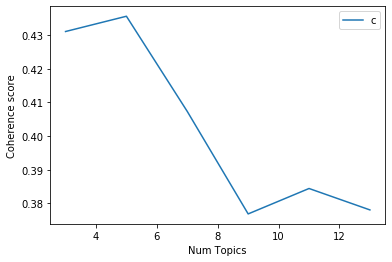

In [41]:
limit = 15
start = 3
step = 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4311
Num Topics = 5  has Coherence Value of 0.4356
Num Topics = 7  has Coherence Value of 0.4073
Num Topics = 9  has Coherence Value of 0.3769
Num Topics = 11  has Coherence Value of 0.3844
Num Topics = 13  has Coherence Value of 0.3781


## Sentiment

In [53]:
def vader_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)

In [54]:
def polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment[0]

def subjectivity(text):
    analysis = TextBlob(text)
    return analysis.sentiment[1]

In [55]:
def topic_sent(sentence_tokens):
    s_tokens = sentence_tokens
    topic_0 = 0
    topic_1 = 0
    topic_2 = 0
    topic_3 = 0
    topic_4 = 0
    num_sentences = len(s_tokens)
    for i in range(num_sentences):
        tokens = s_tokens[i].split()
        vec = id2word.doc2bow(tokens)
        topic = sorted(ldamallet[vec], key=lambda tup: tup[1], reverse=True)[0][0]
        sentiment = round(100 * vader_analysis(s_tokens[i])['compound'], 2)
        if topic == 0:
            topic_0 += sentiment / num_sentences
        elif topic == 1:
            topic_1 += sentiment / num_sentences
        elif topic == 2:
            topic_2 += sentiment / num_sentences
        elif topic == 3:
            topic_3 += sentiment / num_sentences
        else:
            topic_4 += sentiment / num_sentences
    return (round(topic_0, 2), round(topic_1, 2), round(topic_2, 2), round(topic_3, 2), round(topic_4, 2))

In [ ]:
df2 = pd.DataFrame()
df2['Sentiment'] = df['sentence_tokens'].map(topic_sent)

In [ ]:
df2['Student'] = df2['Sentiment'].map(lambda x: x[0])
df2['Police'] = df2['Sentiment'].map(lambda x: x[1])
df2['Protests'] = df2['Sentiment'].map(lambda x: x[2])
df2['Government'] = df2['Sentiment'].map(lambda x: x[3])
df2['Economy'] = df2['Sentiment'].map(lambda x: x[4])
df2['Source'] = df['source']

In [ ]:
df2.groupby('Source')['Student'].mean()

In [ ]:
df2.groupby('Source')['Police'].mean()

In [ ]:
df2.groupby('Source')['Government'].mean()

In [ ]:
df2.groupby('Source')['Protests'].mean()

In [ ]:
df2.groupby('Source')['Economy'].mean()